<a href="https://colab.research.google.com/github/puneat/Algorithmic_Portfolio/blob/puneet/Portfolio_Investment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

In [136]:
sp500_hist_data = pd.read_csv('/gdrive/My Drive/UBS/close_price.csv')
sp500_companies = pd.read_csv('/gdrive/My Drive/UBS/company_data.csv')
secondary_index_data = pd.read_csv('/gdrive/My Drive/UBS/secondary_data.csv')

In [127]:
def read_price_data(idx):
  open = pd.read_csv('/gdrive/My Drive/UBS/open_price.csv')
  close = pd.read_csv('/gdrive/My Drive/UBS/close_price.csv')
  high = pd.read_csv('/gdrive/My Drive/UBS/high_price.csv')
  low = pd.read_csv('/gdrive/My Drive/UBS/low_price.csv')
  bb_live = pd.read_csv('/gdrive/My Drive/UBS/bb_live.csv')
  volume = pd.read_csv('/gdrive/My Drive/UBS/volume.csv')

  open=open.iloc[:,[0,idx]]
  close=close.iloc[:,[0,idx]]
  high=high.iloc[:,[0,idx]]
  low=low.iloc[:,[0,idx]]
  bb_live=bb_live.iloc[:,[0,idx]]
  volume=volume.iloc[:,[0,idx]]

  open=open.set_index('date')
  close=close.set_index('date')
  high=high.set_index('date')
  low=low.set_index('date')
  bb_live=bb_live.set_index('date')
  volume=volume.set_index('date')

  result = pd.concat([open,high,low,close,volume,bb_live], axis=1).reindex(bb_live.index)
  result.columns = ['open','high','low','close','volume','bb_live'] 
  return result

In [105]:
def data_load(idx):
  ind=secondary_index_data
  ind=ind.dropna()
  equity=sp500_hist_data.iloc[:,[0,idx]]
  missing_values = set(ind.iloc[:, 0]).symmetric_difference(set(equity.iloc[:, 0]))
  missing_values=list(missing_values)
  #print(len(missing_values))
  ind = ind[~ind['date'].isin(missing_values)]
  equity = equity[~equity['date'].isin(missing_values)]
  ind=ind.iloc[:,1:]
  equity=equity.iloc[:,-1]
  return ind, equity

In [5]:
ind=ind.dropna()

In [6]:
equity=sp500_hist_data[['date','AAPL.US Equity']]

In [7]:
missing_values = set(ind.iloc[:, 0]).symmetric_difference(set(equity.iloc[:, 0]))
missing_values=list(missing_values)
print(len(missing_values))

367


In [8]:
ind = ind[~ind['date'].isin(missing_values)]

In [9]:
equity = equity[~equity['date'].isin(missing_values)]

In [10]:
ind.shape, equity.shape

((2157, 17), (2157, 2))

In [11]:
ind=ind.iloc[:,1:]
equity=equity.iloc[:,-1]

In [61]:
#creating a corr matrix wrt to class labels
corr_matrix=[]
for idx in range(1,ind.shape[1]): 
  corr=np.corrcoef(ind.iloc[:,idx].to_numpy(),equity['AAPL.US Equity'].to_numpy())
  #print(corr)
#Converting coeeficient to percentage
  corr_matrix.append(corr[0,1]*100)
#print(corr_matrix)

KeyError: ignored

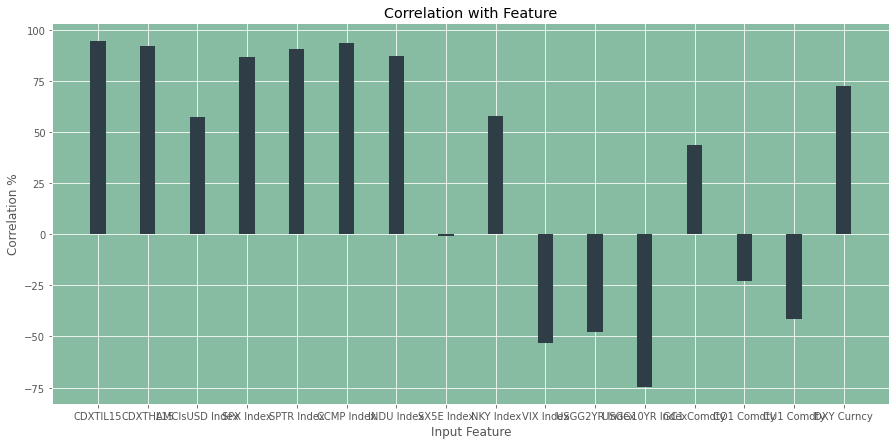

In [16]:
#plotting the correlation for every variable wrt class
matplotlib.style.use('ggplot')
fig = plt.figure(facecolor='w',figsize=(15,7)) # creating a plot figure
ax = fig.add_subplot(111, axisbelow=True,facecolor='#87bba2')
cols = np.linspace(1, 40, 16)
ax.bar(cols,corr_matrix,color='#2f3e46',tick_label=ind.columns[1:])
ax.set_title('Correlation with Feature')
ax.set_xlabel('Input Feature')
ax.set_ylabel('Correlation %')
plt.show()

In [13]:
scaler = StandardScaler()

ind=scaler.fit_transform(ind)

In [155]:
#model parameters
param = {'num_leaves':100, 'objective':'mse','max_depth':7,'learning_rate':0.1,'max_bin':20, 'seed':15, 'verbose': -1}
param['metric'] = ['mse']

#model variables initialisation
model=None
evals_result = {} #store batch results
cum_results = {'training':[], 'valid_1':[]} #store all results

In [140]:
#training loop
trainValidSplit = 0.75
roundPerBatch = 1000
trainx=ind.to_numpy()
trainy=equity.to_numpy()

In [115]:
def input_data(ind,equity):
  trainx=ind.to_numpy()
  trainy=equity.to_numpy()
  trainX, trainY = trainx[400:,:], trainy[400:]
  validX, validY = trainx[:400,:], trainy[:400]
  scaler = StandardScaler()
  trainX=scaler.fit_transform(trainX)
  validX=scaler.transform(validX)
  return trainX, trainY, validX, validY

In [32]:
trainX, trainY = trainx[200:,:], trainy[200:]
validX, validY = trainx[:200,:], trainy[:200]

In [33]:
scaler = StandardScaler()

trainX=scaler.fit_transform(trainX)
validX=scaler.transform(validX)

In [52]:
trainX.shape, trainY.shape, validX.shape, validY.shape

((1957, 16), (1957,), (200, 16), (200,))

In [156]:
#training loop
#build training and validation gbm dataset objects
for i in range(43,44):
  ind, equity = data_load(i)
  trainX, trainY, validX, validY = input_data(ind,equity)
  train_data = lgb.Dataset(trainX, label=trainY)
  validation_data = lgb.Dataset(validX,label=validY)
  #train model
  model = lgb.train(param, train_data, roundPerBatch,
                      valid_sets=[train_data, validation_data],
                      evals_result=evals_result,
                      verbose_eval=1,init_model=model)
  cum_results['training'] += (evals_result['training']['l2'])
  cum_results['valid_1'] += (evals_result['valid_1']['l2'])
  #if i != int((sp500_hist_data.shape[1]/2)-1):
   # del ind,equity,trainX, trainY, validX, validY,train_data,validation_data

[1]	training's l2: 31080.1	valid_1's l2: 52611.8
[2]	training's l2: 25302.6	valid_1's l2: 50306.9
[3]	training's l2: 20618.6	valid_1's l2: 46884.5
[4]	training's l2: 16816.5	valid_1's l2: 45530
[5]	training's l2: 13739.3	valid_1's l2: 42550.8
[6]	training's l2: 11236.9	valid_1's l2: 40942
[7]	training's l2: 9205.45	valid_1's l2: 36578.7
[8]	training's l2: 7560.54	valid_1's l2: 33019.8
[9]	training's l2: 6224.83	valid_1's l2: 30503.3
[10]	training's l2: 5137.92	valid_1's l2: 27892.5
[11]	training's l2: 4255.05	valid_1's l2: 25656.6
[12]	training's l2: 3530.67	valid_1's l2: 23737.2
[13]	training's l2: 2941.41	valid_1's l2: 22385.7
[14]	training's l2: 2462.25	valid_1's l2: 20945.5
[15]	training's l2: 2071.36	valid_1's l2: 20011.8
[16]	training's l2: 1752.66	valid_1's l2: 19319.4
[17]	training's l2: 1490.93	valid_1's l2: 18611.5
[18]	training's l2: 1279.25	valid_1's l2: 18032.1
[19]	training's l2: 1103.86	valid_1's l2: 17564.9
[20]	training's l2: 944.273	valid_1's l2: 17140.4
[21]	training

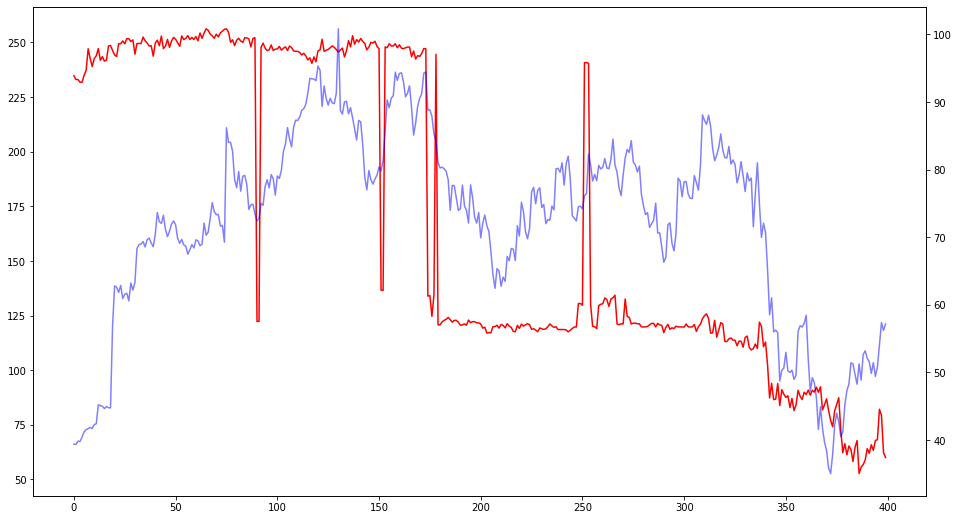

In [157]:
ypred = model.predict(validX)

fig, ax1 = plt.subplots(figsize=(16, 9))
ax2 = ax1.twinx()
ax1.plot(ypred,color='red')
ax2.plot(validY,color='blue',alpha=0.5)

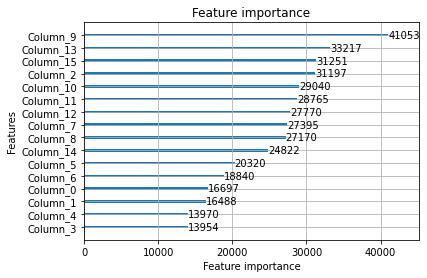

In [36]:
lgb.plot_importance(model, max_num_features=16);

In [ ]:
asset_price['Date'] = asset_price.index
#asset_price.drop(asset_price.tail(3).index,inplace=True)
asset_price=asset_price.iloc[::-1]
asset_price['Date'] = asset_price['Date'].dt.strftime('%Y-%m-%d')

In [ ]:
asset_price.tail()

,High,Low,Open,Close,Volume,Adj Close,Date
Date,,,,,,,
2019-01-08,1676.609985,1616.609985,1664.689941,1656.579956,8881400,1656.579956,2019-01-08
2019-01-07,1634.560059,1589.189941,1602.310059,1629.510010,7993200,1629.510010,2019-01-07
2019-01-04,1594.000000,1518.310059,1530.000000,1575.390015,9182600,1575.390015,2019-01-04
2019-01-03,1538.000000,1497.109985,1520.010010,1500.280029,6975600,1500.280029,2019-01-03
2019-01-02,1553.359985,1460.930054,1465.199951,1539.130005,7983100,1539.130005,2019-01-02


In [ ]:
asset_price.head()

,High,Low,Open,Close,Volume,Adj Close,Date
Date,,,,,,,
2020-09-11,3217.340820,3112.800049,3307.219971,3128.399902,2412130,3128.399902,2020-09-11
2020-09-10,3349.889893,3170.550049,3307.219971,3175.110107,5313300,3175.110107,2020-09-10
2020-09-09,3303.179932,3185.000000,3202.989990,3268.610107,5188700,3268.610107,2020-09-09
2020-09-08,3250.850098,3130.000000,3144.000000,3149.840088,6094200,3149.840088,2020-09-08
2020-09-04,3381.500000,3111.129883,3318.000000,3294.620117,8781800,3294.620117,2020-09-04


In [ ]:
import quandl
risk_free_rate=quandl.get("FRED/DTB3", authtoken="ynpGTyL_Yyqncv9B_f-z",start_date=str(asset_price.Date[-1]), end_date=str(asset_price.Date[0]))

In [ ]:
risk_free_rate['Date'] = risk_free_rate.index
risk_free_rate=risk_free_rate.iloc[::-1]
risk_free_rate['Date'] = risk_free_rate['Date'].dt.strftime('%Y-%m-%d')

In [ ]:
risk_free_rate.head()

,Value,Date
Date,,
2020-09-09,0.12,2020-09-09
2020-09-08,0.13,2020-09-08
2020-09-04,0.11,2020-09-04
2020-09-03,0.11,2020-09-03
2020-09-02,0.12,2020-09-02


In [ ]:
risk_free_rate.tail()

,Value,Date
Date,,
2019-01-08,2.41,2019-01-08
2019-01-07,2.41,2019-01-07
2019-01-04,2.37,2019-01-04
2019-01-03,2.36,2019-01-03
2019-01-02,2.37,2019-01-02


In [ ]:
# risk_free_rate.dropna(inplace=True)
# # risk_free_rate['Date'] = pd.to_datetime(risk_free_rate.Date)
# # risk_free_rate['Date'] = risk_free_rate['Date'].dt.strftime('%Y-%m-%d')
# risk_free_rate.head()

In [ ]:
missing_values = set(asset_price.iloc[:, 6]).symmetric_difference(set(risk_free_rate.iloc[:, 1]))
missing_values=list(missing_values)
print(missing_values)

['2019-10-14', '2020-09-10', '2019-11-11', '2020-09-11']


In [ ]:
asset_price = asset_price[~asset_price['Date'].isin(missing_values)]

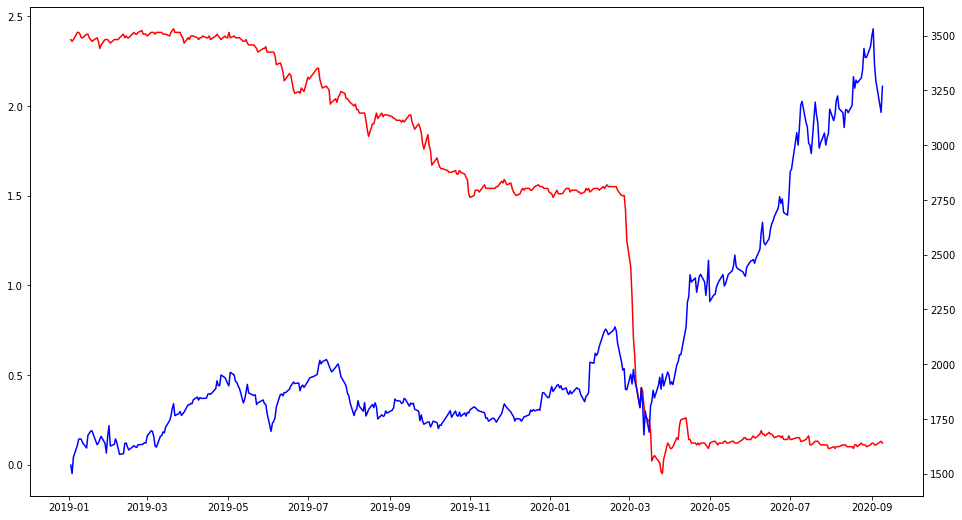

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
fig, ax1 = plt.subplots(figsize=(16, 9))
ax2 = ax1.twinx()
ax1.plot(risk_free_rate.Value,color='red')
ax2.plot(asset_price.Close,color='blue')

In [ ]:
import numpy as np
log_returns_list=[]
for idx in range(1,len(asset_price)):
  daily_log_returns=np.log(asset_price['Adj Close'][idx]/asset_price['Adj Close'][idx-1])
  log_returns_list.append(daily_log_returns)

In [ ]:
asset_price_std=np.std(log_returns_list)
asset_price_volatility=(asset_price_std*252)**0.5
asset_price_mean=np.mean(log_returns_list)
print('Annualized Volatility is: {:f}'.format(asset_price_volatility))
print('Annualized Mean is: {:f}'.format(asset_price_mean))
print('Annualized STD is: {:f}'.format(asset_price_std))

Annualized Volatility is: 2.221490
Annualized Mean is: -0.001780
Annualized STD is: 0.019583


In [ ]:
asset_price['Close'][0],risk_free_rate['Value'][0]

(3268.610107421875, 0.12)

In [ ]:
next_day_price_vector[0]

[93.39564793049905,
 93.0539934967495,
 93.16683922245473,
 93.29846956439671,
 92.32642735273572]

In [ ]:
asset_price_mean-((asset_price_std**2)/2)


-0.001972245384550291

In [ ]:
from random import gauss
import random
from scipy.stats import norminvgauss
from scipy.stats import norminvgauss

drift=asset_price_mean-((asset_price_std**2)/2)
sims=500
days=50

def mcs(sims,days,drift,asset_price_std,asset_price):
  next_day_price_vector=[[0]*sims]*days
  for i in range(0,sims):
    next_day_price_vector[0][i]=asset_price.Close[0]

  for j in range(0,sims):
    for i in range(1,days):
      random_value=norm.ppf(random.randint(0.0,1.0),0,1)*asset_price_std
      next_day_price_vector[i][j]=next_day_price_vector[i-1][j]*np.exp(drift+random_value)
  return next_day_price_vector
pun=mcs(sims,days,drift,asset_price_std,asset_price)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
pun

[[nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,

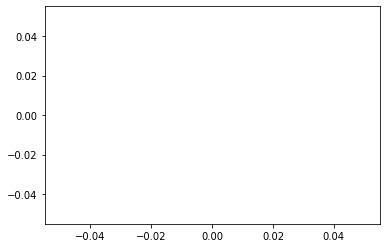

In [ ]:
plt.plot(pun)

In [ ]:
sim_number=1000000
prices=[]
drift=asset_price_mean-((asset_price_std**2)/2)
for num in range(0,sim_number):
  prices.append(forecast_future_asset_price(2,log_returns_list,0))
print(np.mean(prices))

KeyboardInterrupt: ignored

In [ ]:
from random import gauss
def forecast_future_asset_price(days,log_return_list,idx):
  expected_price=asset_price['Close'][idx]*(np.exp((risk_free_rate['Value'][idx]-
                                                          ((0.5*asset_price_volatility)**2)*(days/365))+
                                                         (asset_price_volatility*gauss(0.0,1.0)*np.sqrt(days/365))))

  return 0.87*expected_price #PUNEET's CONSTANT=0.85 idk why but works

In [ ]:
sim_number=1000000
prices=[]
for num in range(0,sim_number):
  prices.append(forecast_future_asset_price(2,log_returns_list,0))
print(np.mean(prices))